In [1]:
import time
import random
import os
import sys
import pandas as pd
from collections import OrderedDict
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from scipy import interpolate
from scipy.interpolate import LinearNDInterpolator
sys.path.insert(0, '../Utilities/')

mpl.rcParams.update(mpl.rcParamsDefault)
np.set_printoptions(threshold=sys.maxsize)
np.random.seed(1234)
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 19
lc = (0.2, 0.2, 0.2)
cmap = 'RdBu'
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in [0, 0.2, 0.3, 0.7, 0.8, 1.0]]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

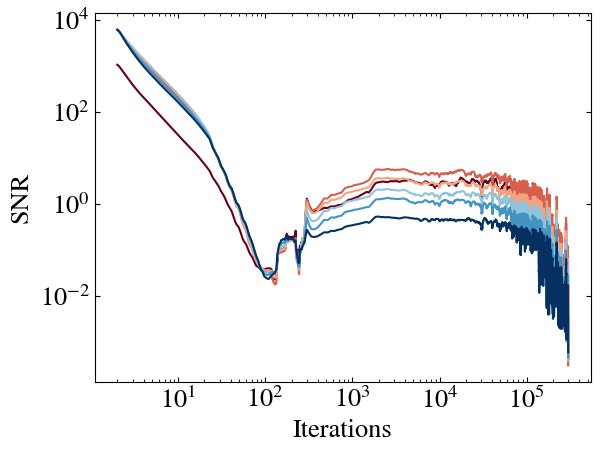

In [2]:

def plot_snr_layers(lp=0, files=None, mode='snr', iters=None, window=0, layers=None, lgnd=0):
    labels = 1
    hd = layers + 1  # Hidden layers
    skip = layers*0 # skip iterations
    df = pd.read_csv(files[0])
    stats = df[['Epoch', 'Layer', 'Mean', 'Std', 'L2']] # .to_numpy()
    
    # print(stats[lp::hd].head())  # check head
    # skip rows
    rows = np.arange(skip + lp, len(stats), hd)
    stats = stats.iloc[rows]
    it, mean, std, l2 = stats['Epoch'], stats['Mean'], stats['Std'], stats['L2']

    # Keep data until specific iteration
    if iters != None:
        iters = np.where(it == iters)[0][0]
        it = it[:iters]
        mean = mean[:iters]
        std = std[:iters]
        l2 = l2[:iters]
    
    if mode == 'l2':
        window_size = 0
    else:
        window_size = window

    # Smoothing noisy SNR curves
    if window_size > 0:
        it0, itn = pd.Series([it.iloc[0]] * window), pd.Series([it.iloc[-1]] * window)
        mean0, meann = pd.Series([mean.iloc[0]] * window), pd.Series([mean.iloc[-1]] * window)
        std0, stdn = pd.Series([std.iloc[0]] * window), pd.Series([std.iloc[-1]] * window)

        it = pd.concat([it0, it, itn], ignore_index=True)
        mean = pd.concat([mean0, mean, meann], ignore_index=True)
        std = pd.concat([std0, std, stdn], ignore_index=True)

        a, b, c = [], [], []
        for ii in range(it.size):
            a.append(it[ii:ii+window].mean())
            b.append(mean[ii:ii+window].mean())
            c.append(std[ii:ii+window].mean())
        it, mean, std = np.array(a), np.array(b), np.array(c)

    if mode == 'vals':
        return it, mean, std, l2
    if mode == 'std':
        plt.plot(it, std, label="layer"+str(lp+1))
        if labels == 1: plt.ylabel(r'||$\sigma$||')
    elif mode == 'mu':
        plt.plot(it, mean, label="layer "+str(lp+1))
        if labels == 1: plt.ylabel(r'||$\mu$||')
    elif mode == 'snr':
        plt.plot(it, mean/std, label="layer "+str(lp+1))
        if labels == 1: plt.ylabel("SNR")
    elif mode == 'l2':
        plt.plot(it, l2, label="μ"+str(lp))
        if labels == 1: plt.ylabel("||w||")
    if labels == 1: plt.xlabel("Iterations")

    if lgnd != 0:
        if mode == 'mu':
            plt.legend(loc='lower left')
        if mode=='l2':
            plt.legend(loc='lower left')
        else:
            plt.legend(loc='lower left', handletextpad=0.3, labelspacing=0.1, borderpad=0.1)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
    plt.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True)

# file = 'Results/AC/v/grad_stats2.txt'  # new
# file = 'Results/AC/r/grad_stats2.txt'  # new

# file = 'Results/HM/t/grad_stats2.txt'  # new
# file = 'Results/HM/Vanilla/grad_stats2.txt'  # new

file = 'Results/HM/r2/grad_stats2.txt'

layers = 6
for i in range(0, layers):
    plot_snr_layers(i, [file], mode='snr', window=20, layers=layers)
    
plt.show()

In [3]:
mpl.rcParams['font.size'] = 16

def full_snr(ff, c, title='snr', adam=0, out=0, lg=None, layers=None, lgnd=None, window=1):

    file = 'Results/'+ff+'.txt'

    it, mean, std, l2 = plot_snr_layers(i, [file], mode='vals', window=window, layers=layers, lgnd=lgnd)
    sz = len(it) - 1
    mu_sum = mean[:sz]
    std_sum = std[:sz]
    it = it[:sz]

    if c == 'midnightblue':
        tt = 'SNR'
    else:
        tt = r'$Order \ \phi$'

    if adam == 0:
        if title == 'snr':
            plt.plot(it, mu_sum/std_sum, label=tt, c=c)
        elif title == 'mu':
            plt.plot(it, mu_sum, label=r'$||\mu||_2$', c=c)
        elif title == 'std':
            plt.plot(it, std_sum, label=r'$||\sigma||_2$', c=c)
        else:
            plt.plot(it, mu_sum/std_sum, label=title, c=c)
    else:
        if c=='orange':
            phi = mu_sum/std_sum
            plt.plot(it, phi/np.sqrt(1-phi**2), label=title, c=c)
        else:
            plt.plot(it, mu_sum/std_sum, label=title, c=c)

    # if lgnd != None:
    #     plt.legend(loc='upper right')

    if lg == 1:
        plt.xscale('log')
    else:
        plt.xscale('log')
        plt.yscale('log')

    plt.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
    plt.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True)

    if out == 1:
        return mu_sum/std_sum, it

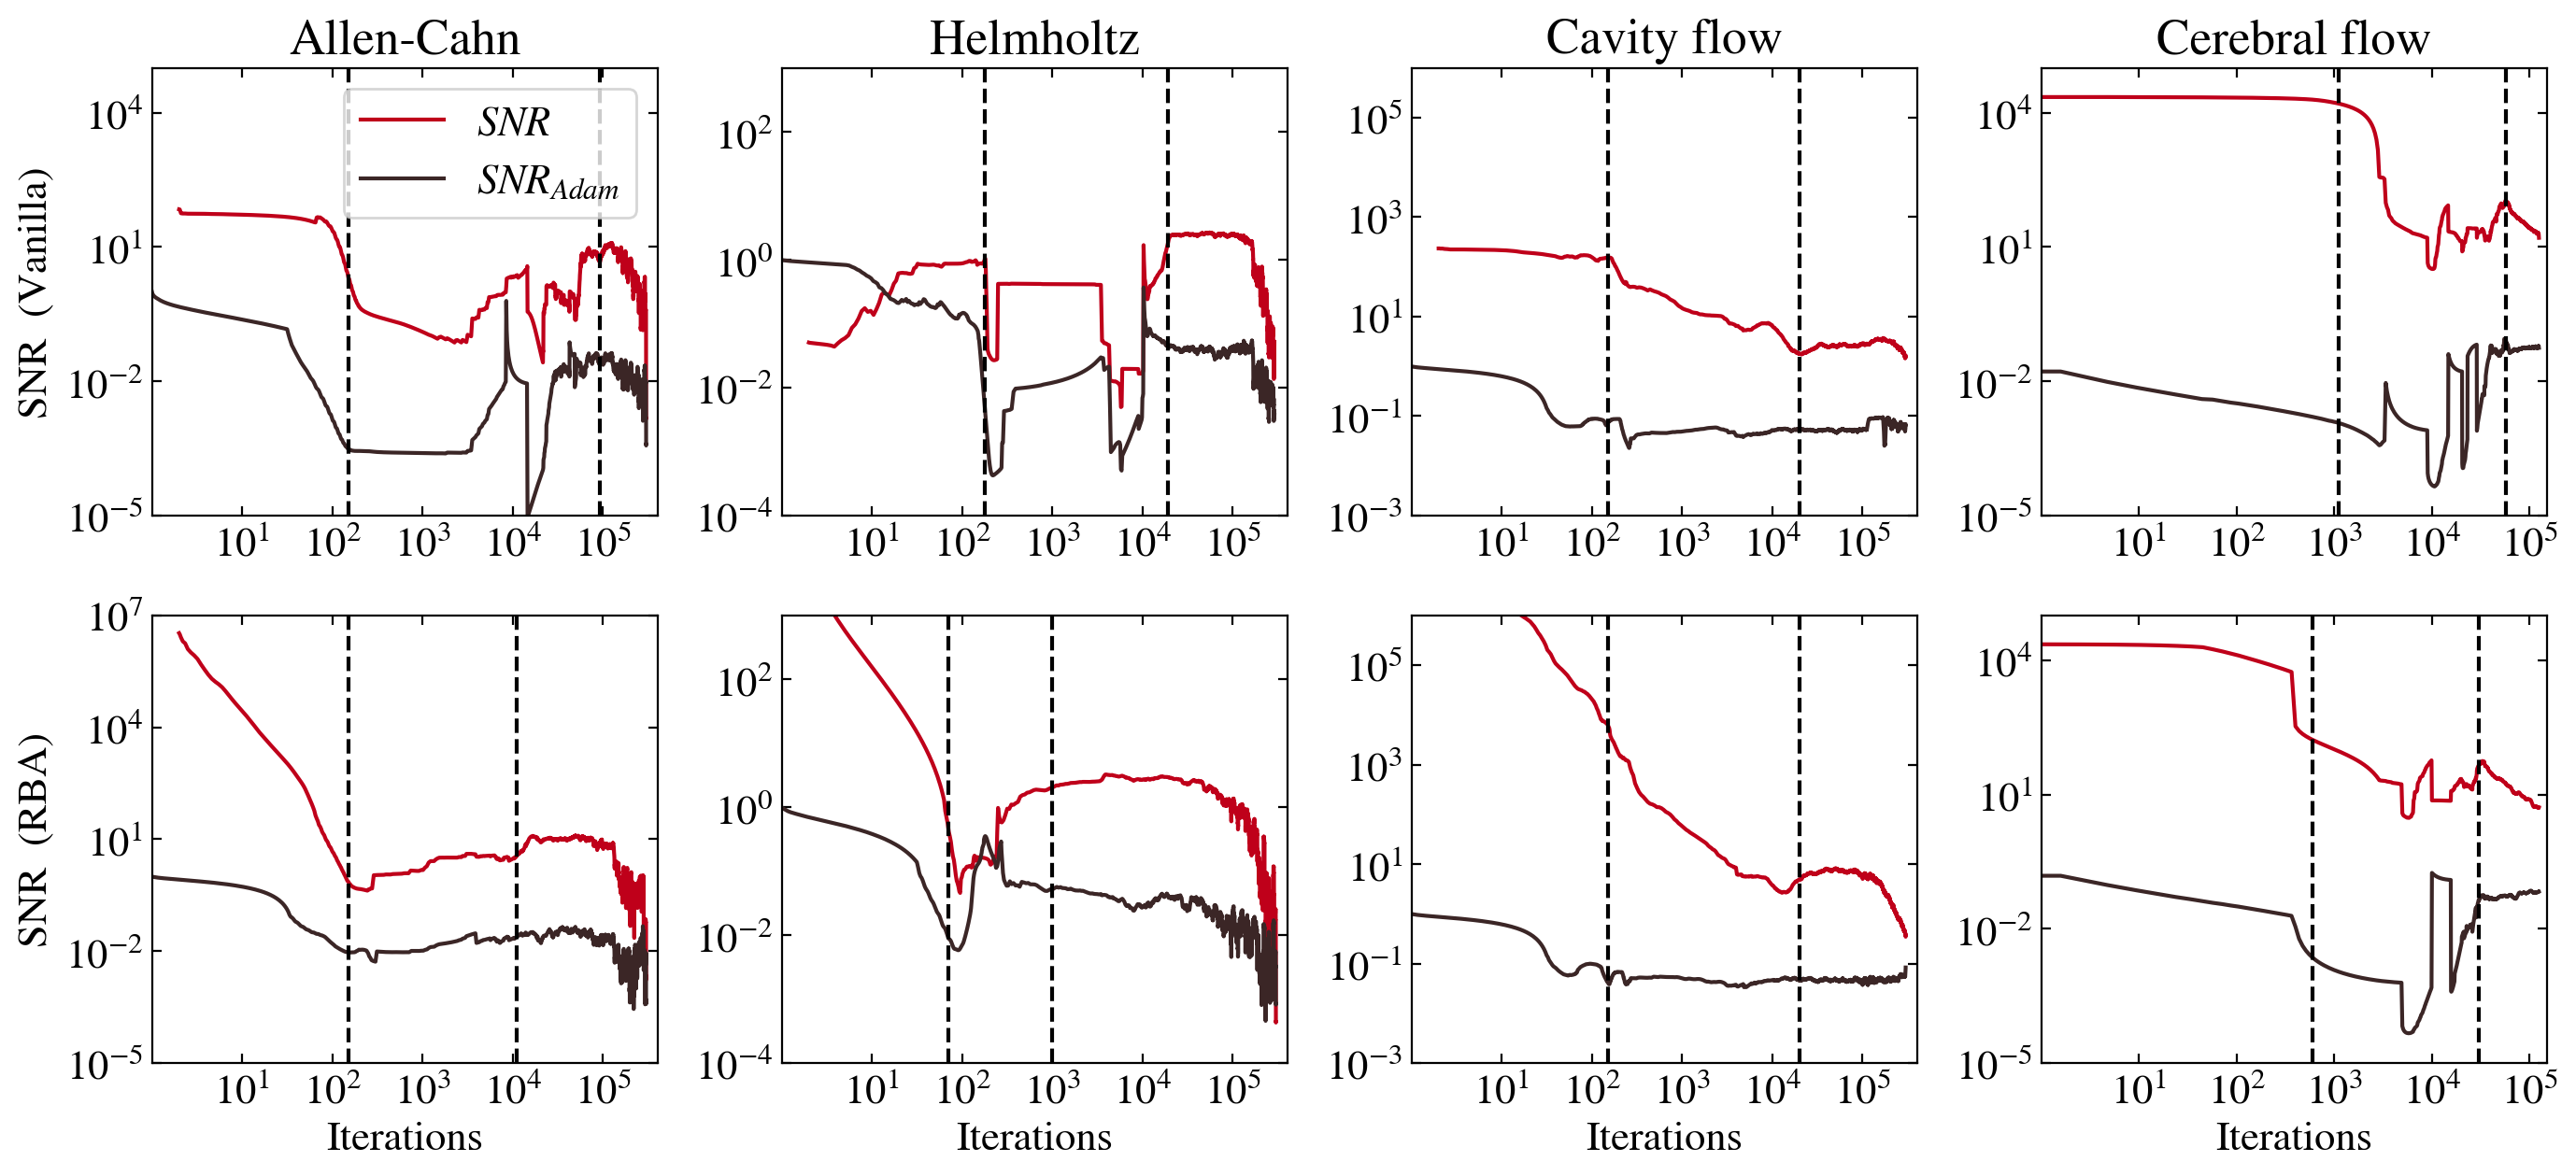

In [4]:
cg = (0.75, 0.0, 0.1) #'crimson'
cr = (0.23, 0.15, 0.15) #'royalblue'
mpl.rcParams['font.size'] = 16
x1, y1 = np.linspace(0, 5e5, 100), np.ones(100)
wnd = 60

def plot_subplot(i):
    # plt.plot(x1, y1, '--', c='black')
    if i == 0:
        full_snr('AC/v/grad_stats', cg, layers=6, lgnd=1, window=wnd, title=r'$SNR$')
        full_snr('AC/v/grad_stats0', cr, layers=6, lgnd=1, window=wnd, title=r'$SNR_{Adam}$')
        plt.axvline(x=91700, linestyle='--', color='black')
        plt.axvline(x=150, linestyle='--', color='black')
        plt.title('Allen-Cahn')
        plt.ylim([1e-5, 1e5])
        plt.xlim([1, 4e5]) #plt.xlim([4, 4e5])
    elif i == 4:
        full_snr('AC/r/grad_stats', cg, layers=6, window=wnd)
        full_snr('AC/r/grad_stats0', cr, layers=6, window=wnd)
        plt.axvline(x=11100, linestyle='--', color='black')
        plt.axvline(x=150, linestyle='--', color='black')
        plt.ylim([1e-5, 1e7])
        # plt.ylim([.4, 1.5])
        plt.xlim([1, 4e5]) #plt.xlim([4, 4e5])
    elif i == 1:
        full_snr('HM/v/grad_stats', cg, layers=6, window=wnd)
        full_snr('HM/v/grad_stats0', cr, layers=6, window=wnd)
        plt.title('Helmholtz')
        plt.axvline(x=19000, linestyle='--', color='black')
        plt.axvline(x=180, linestyle='--', color='black')
        plt.ylim([1e-4, 1e3])
        plt.xlim([1, 4e5]) #plt.xlim([4, 4e5])
    elif i == 5:
        full_snr('HM/r2/grad_stats',  cg, layers=6, window=wnd)
        full_snr('HM/r2/grad_stats0',  cr, layers=6, window=wnd)
        plt.axvline(x=1000, linestyle='--', color='black')
        plt.axvline(x=70, linestyle='--', color='black')
        plt.ylim([1e-4, 1e3])
        plt.xlim([1, 4e5]) #plt.xlim([4, 4e5])
    elif i == 2:
        full_snr('CV/v/grad_stats', cg, layers=6, window=wnd)
        full_snr('CV/v/grad_stats0', cr, layers=6, window=wnd)
        plt.axvline(x=20000, linestyle='--', color='black')
        plt.axvline(x=150, linestyle='--', color='black')
        plt.title('Cavity flow')
        plt.ylim([1e-3, 1e6])
        plt.xlim([1, 4e5]) #plt.xlim([4, 4e5])
    elif i == 6:
        full_snr('CV/r/grad_stats', cg, layers=6, window=wnd)
        full_snr('CV/r/grad_stats0', cr, layers=6, window=wnd)
        plt.axvline(x=20000, linestyle='--', color='black')
        plt.axvline(x=150, linestyle='--', color='black')
        plt.ylim([1e-3, 1e6])
        plt.xlim([1, 4e5]) #plt.xlim([4, 4e5])
    elif i == 3:
        full_snr('BN/v/grad_stats', cg, layers=8, window=wnd)
        full_snr('BN/v/grad_stats0',  cr, layers=8, window=wnd)
        plt.axvline(x=57000, linestyle='--', color='black')
        plt.axvline(x=1100, linestyle='--', color='black')

        plt.title('Cerebral flow')
        plt.ylim([1e-5, 1e5])
        plt.xlim([1, 1.5e5]) #plt.xlim([4, 4e5])
    elif i == 7:
        full_snr('BN/r/grad_stats', cg, layers=8, window=wnd)
        full_snr('BN/r/grad_stats0',  cr, layers=8, window=wnd)
        plt.axvline(x=30000, linestyle='--', color='black')
        plt.axvline(x=600, linestyle='--', color='black')
        
        plt.ylim([1e-5, 1e5])
        plt.xlim([1, 1.5e5]) #plt.xlim([4, 4e5])
    pass
        
# Create subplots
plt.figure(figsize=(14, 6.5), dpi=200)

titles = ['Allen-Cahn RBA', 'Helmholtz RBA', 'Burgers RBA', 'Allen-Cahn vanilla', 'Helmholtz vanilla', 'Burgers vanilla',]
for i in range(8):
    ax = plt.subplot(2, 4, i+1)
    plot_subplot(i)
    # plt.minorticks_on()
    # plt.title(titles[i])
    if i == 0:
        plt.legend(loc='upper right')
    if i > 3:
        plt.xlabel('Iterations')
    if i == 0:
        plt.ylabel('SNR  (Vanilla)')
    elif i == 4:
        plt.ylabel('SNR  (RBA)')
    if i < 4:
        # plt.xticks([])
        plt.xticks([10, 100, 1000, 10000, 100000], ['$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$'])
    else:
        plt.xticks([10, 100, 1000, 10000, 100000], ['$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$'])
    # plt.minorticks_on()  # Ensure minor ticks are enabled
    ax.tick_params(axis='x', which='minor', bottom=True)
    ax.tick_params(axis='y', which='minor', left=False)
    ax.tick_params(axis='y', which='minor', right=False)
    ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True)
    ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True)

plt.tight_layout(pad=0.9)
# Show plot
plt.show()
# plt.savefig('adam_rms.png', dpi=300)


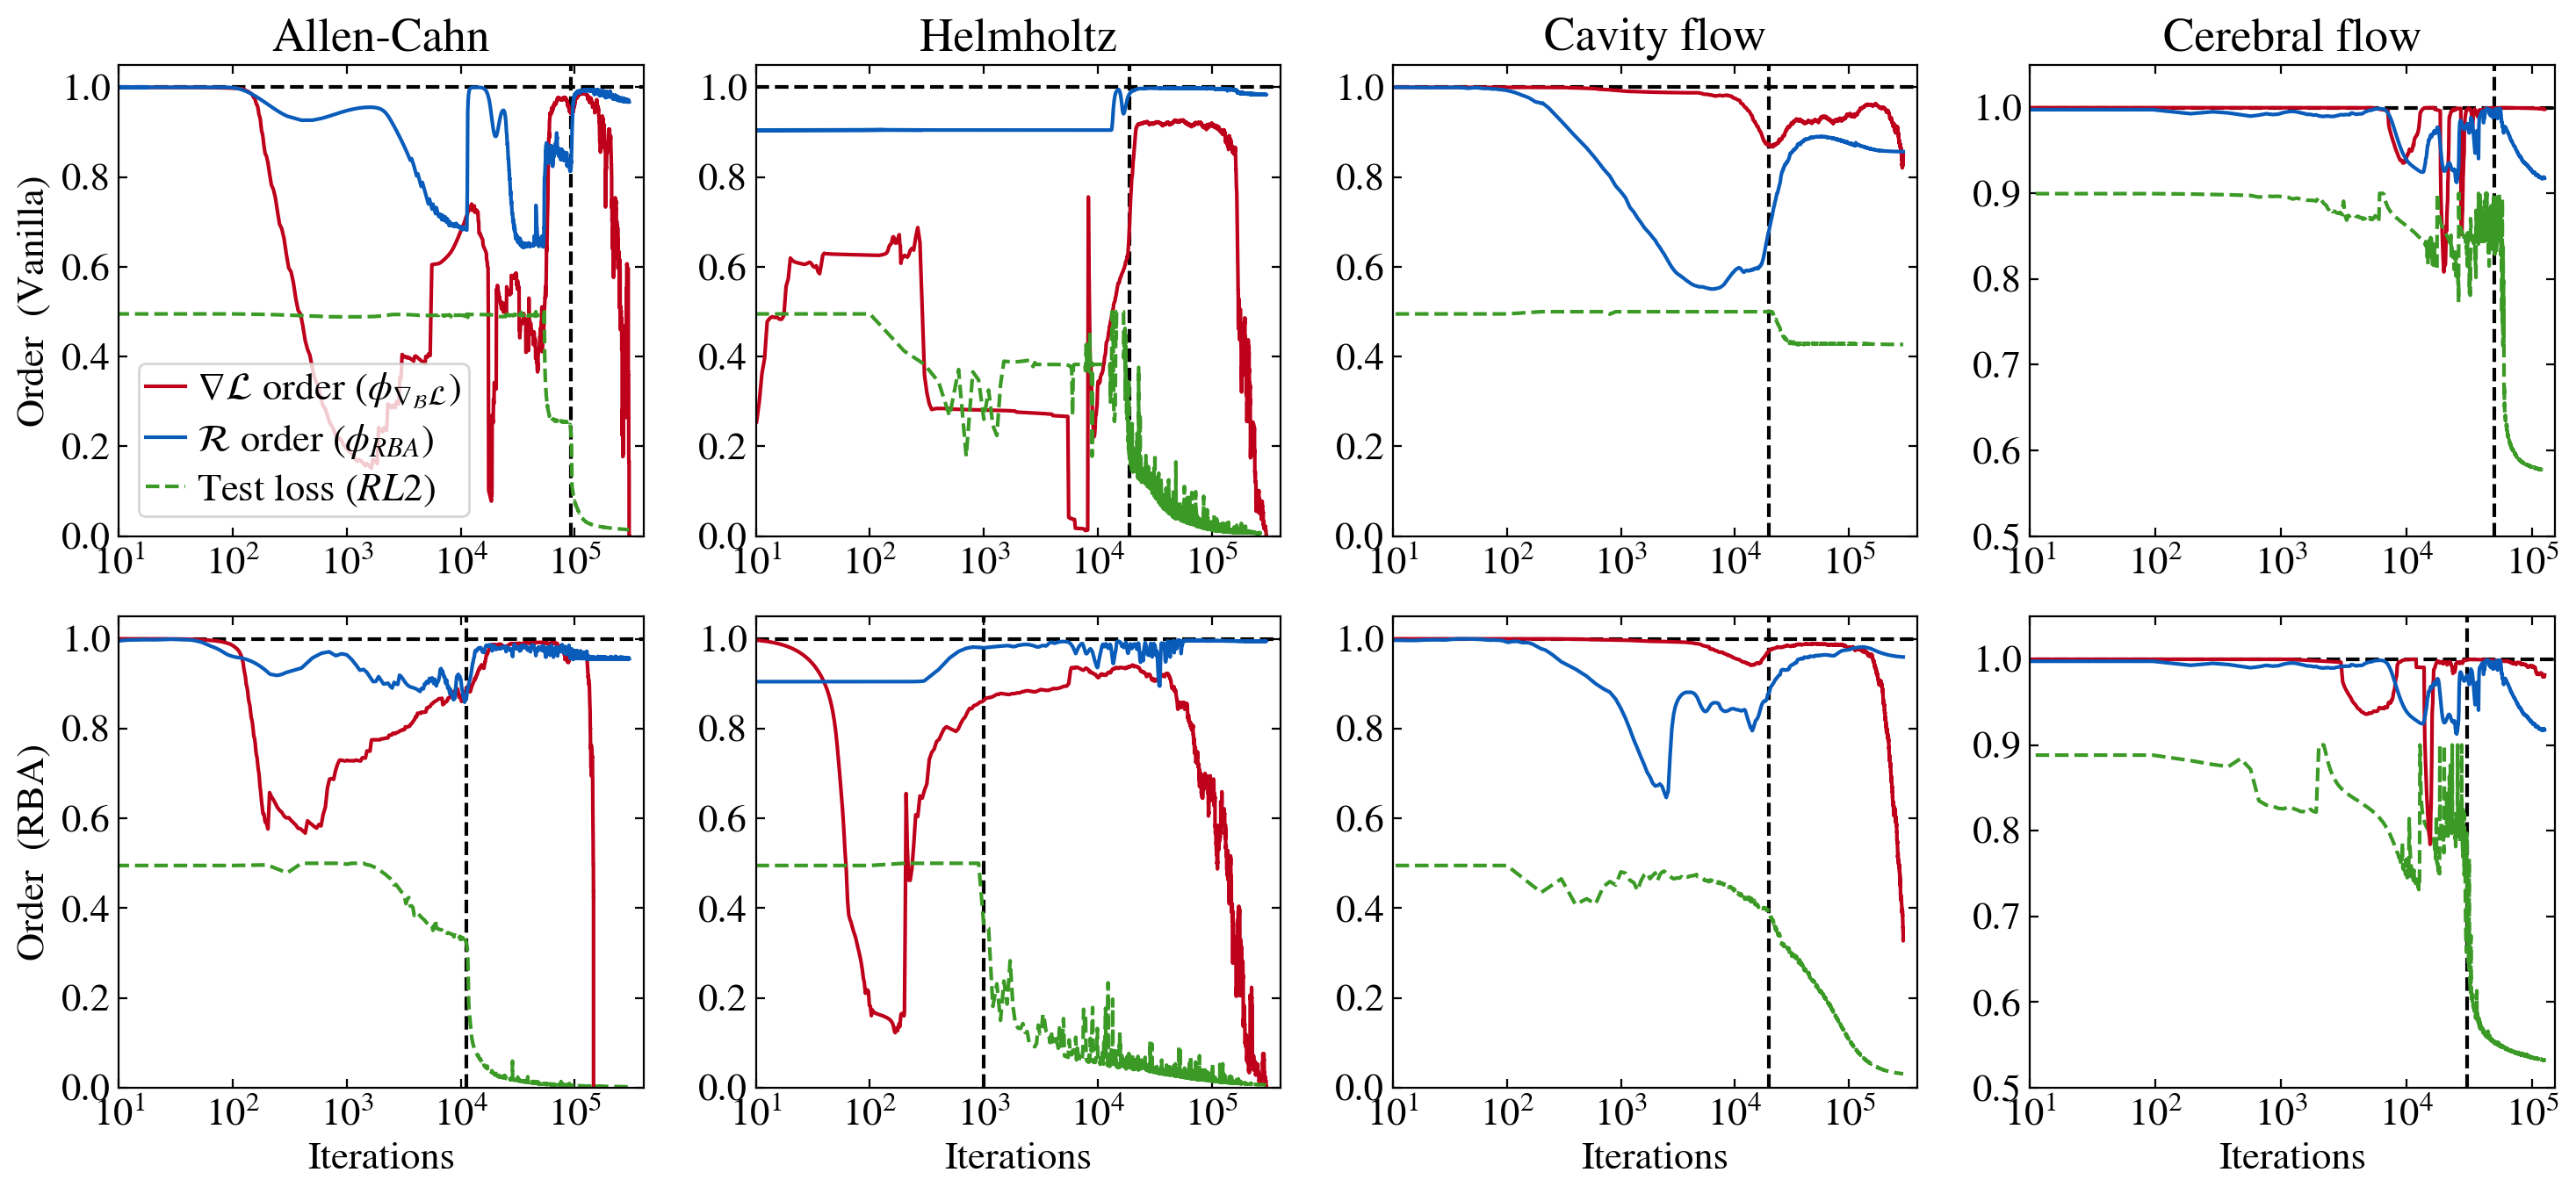

In [5]:
mpl.rcParams['font.size'] = 16
x1, y1 = np.linspace(0, 5e5, 100), np.ones(100)

def losses(ff, c='black', lg=1, window=0, bn=0):

    if bn != 1:
        file = 'Results/'+ff+'.txt'
        a = np.loadtxt(file)

        it = a[:, 0]
        l2 = a[:, 1]
        l2[0] = l2[1]*1.01
    else:
        if 'v' in ff:
            data0 = scipy.io.loadmat('Results/BN/'+'vanilla_res.mat')
        elif 'r' in ff:
            data0 = scipy.io.loadmat('Results/BN/'+'rba_res.mat')
        l2 = (data0["RL2_u"][0, :] + data0["RL2_v"][0, :])/2
        it = np.arange(l2.size)*95

    if window > 0:
        it, l2, l = np.array(it), np.array(l2), np.array(l)

        # Extend arrays with the first and last values
        it = np.concatenate(([it[0]] * window, it, [it[-1]] * window))
        l2 = np.concatenate(([l2[0]] * window, l2, [l2[-1]] * window))
        l = np.concatenate(([l[0]] * window, l, [l[-1]] * window))

        # Compute moving averages
        a, b, c = [], [], []
        for ii in range(len(it) - window + 1):
            a.append(np.mean(it[ii:ii+window]))
            b.append(np.mean(l2[ii:ii+window]))
            c.append(np.mean(l[ii:ii+window]))

        it, l2, l = np.array(a), np.array(b), np.array(c)

    if lg == 1:
        plt.xscale('log')
    elif lg == 2:
        plt.xscale('log')
        plt.yscale('log')

    # filter out large values and scale
    l2[l2>l2[0]] = l2[0]
    l2 /= l2[0]*2.
    if bn == 1:
        l2 += 0.4

    plt.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
    plt.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True)
    plt.plot(it, l2, c=(0.23, 0.6, 0.15), label='Test loss '+r'($RL2$)', linestyle='--')

def plot_phi(file_path, window, color):
    file_path = 'Results/'+file_path
    a = np.arange(0, 20000, 200)
    b = np.arange(20000, 300000, 500)
    it = np.append(a, b)
    batch_size = 100
    phi = []
    txz = np.load(file_path+'residue2/xyz0.npy')
    _, _, zz = txz[:, 0], txz[:, 1], txz[:, 2]
    rba = zz #0
    for i in it:
        txz = np.load(file_path+'residue2/xyz'+str(i)+'.npy')
        _, _, zz = txz[:, 0], txz[:, 1], txz[:, 2]
        sz = zz.size

        rb = np.copy(rba)
        np.random.shuffle(rb)
        rb = rb.reshape(-1, batch_size)
        rm = rb.mean(axis=1)
        phi.append(np.mean(rm)/np.sqrt(np.mean(rb**2)))

    phi = np.array(phi)

    if window > 0:

        # Extend arrays with the first and last values
        it = np.concatenate(([it[0]] * window, it, [it[-1]] * window))
        phi = np.concatenate(([phi[0]] * window, phi, [phi[-1]] * window))

        # Compute moving averages
        a, b = [], []
        for ii in range(len(it) - window + 1):
            a.append(np.mean(it[ii:ii+window]))
            b.append(np.mean(phi[ii:ii+window]))
        it, phi = np.array(a), np.array(b)

    plt.plot(it, phi, color=color)
    # plt.xscale('log')
    # plt.yscale('log')

def plot_subplot(i):
    cg = (0.75, 0.0, 0.1) #'crimson'
    cr = (0.0392, 0.3608, 0.7294) #'royalblue'
    plt.plot(x1, y1, '--', c='black')
    if i == 0:
        plt.axvline(x=91700, linestyle='--', color='black')
        full_snr('AC/v/grad_rms', cg, layers=6, lg=1, window=120, title=r'$\nabla\mathcal{L}$'+' order '+r'($\phi_{\nabla_{\mathcal{B}}\mathcal{L}}$)')
        full_snr('AC/v/res_rms', cr, layers=6, lg=1, window=0, title=r'$\mathcal{R}$'+' order '+r'($\phi_{RBA}$)')
        losses('AC/v/losses')
        
        # plt.legend(loc='lower left')
        plt.legend(
            loc='lower left', 
            handlelength=1,  # Reduces the length of the legend lines
            handletextpad=0.3,  # Reduces the padding between legend lines and text
            borderpad=0.2,  # Reduces padding inside the legend box
            labelspacing=0.3,  # Reduces vertical space between legend entries
            #fontsize='small',  # Use a smaller font size
            frameon=True  # Optionally remove the legend box to save more space
        )
        plt.title('Allen-Cahn')
        plt.ylim([0.0, 1.05])
        plt.xlim([80, 4e5]) #plt.xlim([4, 4e5])

    if i == 4:
        plt.axvline(x=11100, linestyle='--', color='black')
        full_snr('AC/r/grad_rms', cg, layers=6, lg=1, window=120, title=r'$\nabla\mathcal{L}$'+' order '+r'($\phi_{\nabla_{\mathcal{B}}\mathcal{L}}$)')
        full_snr('AC/r/res_rms2', cr, layers=6, lg=1, window=0, title=r'$\mathcal{R}$'+' order '+r'($\phi_{RBA}$)')
        losses('AC/r/losses')
        
        plt.ylim([0.0, 1.05])
        plt.xlim([80, 4e5]) #plt.xlim([4, 4e5])

    if i == 1:
        plt.axvline(x=19000, linestyle='--', color='black')
        full_snr('HM/v/grad_rms', cg, layers=6, lg=1, window=100, title=r'$\nabla\mathcal{L}$'+' order '+r'($\phi_{\nabla_{\mathcal{B}}\mathcal{L}}$)')
        full_snr('HM/v/res_rms', cr, layers=6, lg=1, window=0, title=r'$\mathcal{R}$'+' order '+r'($\phi_{RBA}$)')
        losses('HM/v/losses', window=0)
        plt.title('Helmholtz')
        plt.ylim([0.0, 1.05])
        plt.xlim([80, 4e5]) #plt.xlim([4, 4e5])
    if i == 5:
        plt.axvline(x=1000, linestyle='--', color='black')
        full_snr('HM/r2/grad_rms', cg, layers=6, lg=1, window=100, title=r'$\nabla\mathcal{L}$'+' order '+r'($\phi_{\nabla_{\mathcal{B}}\mathcal{L}}$)')
        full_snr('HM/r2/res_rms', cr, layers=6, lg=1, window=0, title=r'$\mathcal{R}$'+' order '+r'($\phi_{RBA}$)')
        losses('HM/r2/losses', window=0)
        plt.ylim([0.0, 1.05])
        plt.xlim([80, 4e5]) #plt.xlim([4, 4e5])

    if i == 2:
        plt.axvline(x=20000, linestyle='--', color='black')
        full_snr('CV/v/grad_rms', cg, layers=6, lg=1, window=100, title=r'$\nabla\mathcal{L}$'+' order '+r'($\phi_{\nabla_{\mathcal{B}}\mathcal{L}}$)')
        full_snr('CV/v/res_rms', cr, layers=6, lg=1, window=0, title=r'$\mathcal{R}$'+' order '+r'($\phi_{RBA}$)')
        losses('CV/v/losses')
        
        plt.title('Cavity flow')
        plt.ylim([0.0, 1.05])
        plt.xlim([80, 4e5]) #plt.xlim([4, 4e5])
    if i == 6:
        plt.axvline(x=20000, linestyle='--', color='black')
        full_snr('CV/r/grad_rms', cg, layers=6, lg=1, window=100, title=r'$\nabla\mathcal{L}$'+' order '+r'($\phi_{\nabla_{\mathcal{B}}\mathcal{L}}$)')
        full_snr('CV/r/res_rms', cr, layers=6, lg=1, window=0, title=r'$\mathcal{R}$'+' order '+r'($\phi_{RBA}$)')
        losses('CV/r/losses')
        plt.ylim([0.0, 1.05])
        plt.xlim([80, 4e5]) #plt.xlim([4, 4e5])

    if i == 3:
        plt.axvline(x=50000, linestyle='--', color='black')
        full_snr('BN/v/grad_rms', cg, layers=8, lg=1,   window=20, title=r'$\mathcal{R}$'+' order '+r'($\phi_{RBA}$)')
        losses('BN/v/losses', bn=1,)
        
        a = np.loadtxt('Results/Bn/bn_phi_v.txt')
        plt.plot(a[:, 0], a[:, 1], color=cr)
        plt.title('Cerebral flow')
        plt.ylim([0.5, 1.05])
        plt.xlim([80, 1.5e5]) #plt.xlim([4, 4e5])
    if i == 7:
        plt.axvline(x=30000, linestyle='--', color='black')
        
        losses('BN/r/losses', bn=1,)
        # plt.twinx()
        full_snr('BN/r/grad_rms', cg, layers=8, lg=1, window=20, title=r'$\mathcal{R}$'+' order '+r'($\phi_{RBA}$)')
        b = np.loadtxt('Results/Bn/bn_phi_r.txt')
        plt.plot(b[:, 0], b[:, 1], color=cr)
        plt.ylim([0.5, 1.05])
        plt.xlim([80, 1.5e5]) #plt.xlim([4, 4e5])
    pass
        
# Create subplots
plt.figure(figsize=(15, 7), dpi=200)

titles = ['Allen-Cahn RBA', 'Helmholtz RBA', 'Burgers RBA', 'Allen-Cahn vanilla', 'Helmholtz vanilla', 'Burgers vanilla',]
for i in range(8):
    ax = plt.subplot(2, 4, i+1)
    plot_subplot(i)
    # plt.minorticks_on()
    # plt.title(titles[i])
    if i > 3:
        plt.xlabel('Iterations')
    if i == 0:
        plt.ylabel('Order  (Vanilla)')
    elif i == 4:
        plt.ylabel('Order  (RBA)')
    if i < 4:
        # plt.xticks([])
        plt.xticks([10, 100, 1000, 10000, 100000], ['$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$'])
    else:
        plt.xticks([10, 100, 1000, 10000, 100000], ['$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$'])
    # plt.minorticks_on()  # Ensure minor ticks are enabled
    ax.tick_params(axis='x', which='minor', bottom=True)
    ax.tick_params(axis='y', which='minor', left=False)
    ax.tick_params(axis='y', which='minor', right=False)
    ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True)
    ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True)

plt.tight_layout(pad=0.9)
# Show plot
# plt.show()
plt.savefig('order.png', dpi=300)

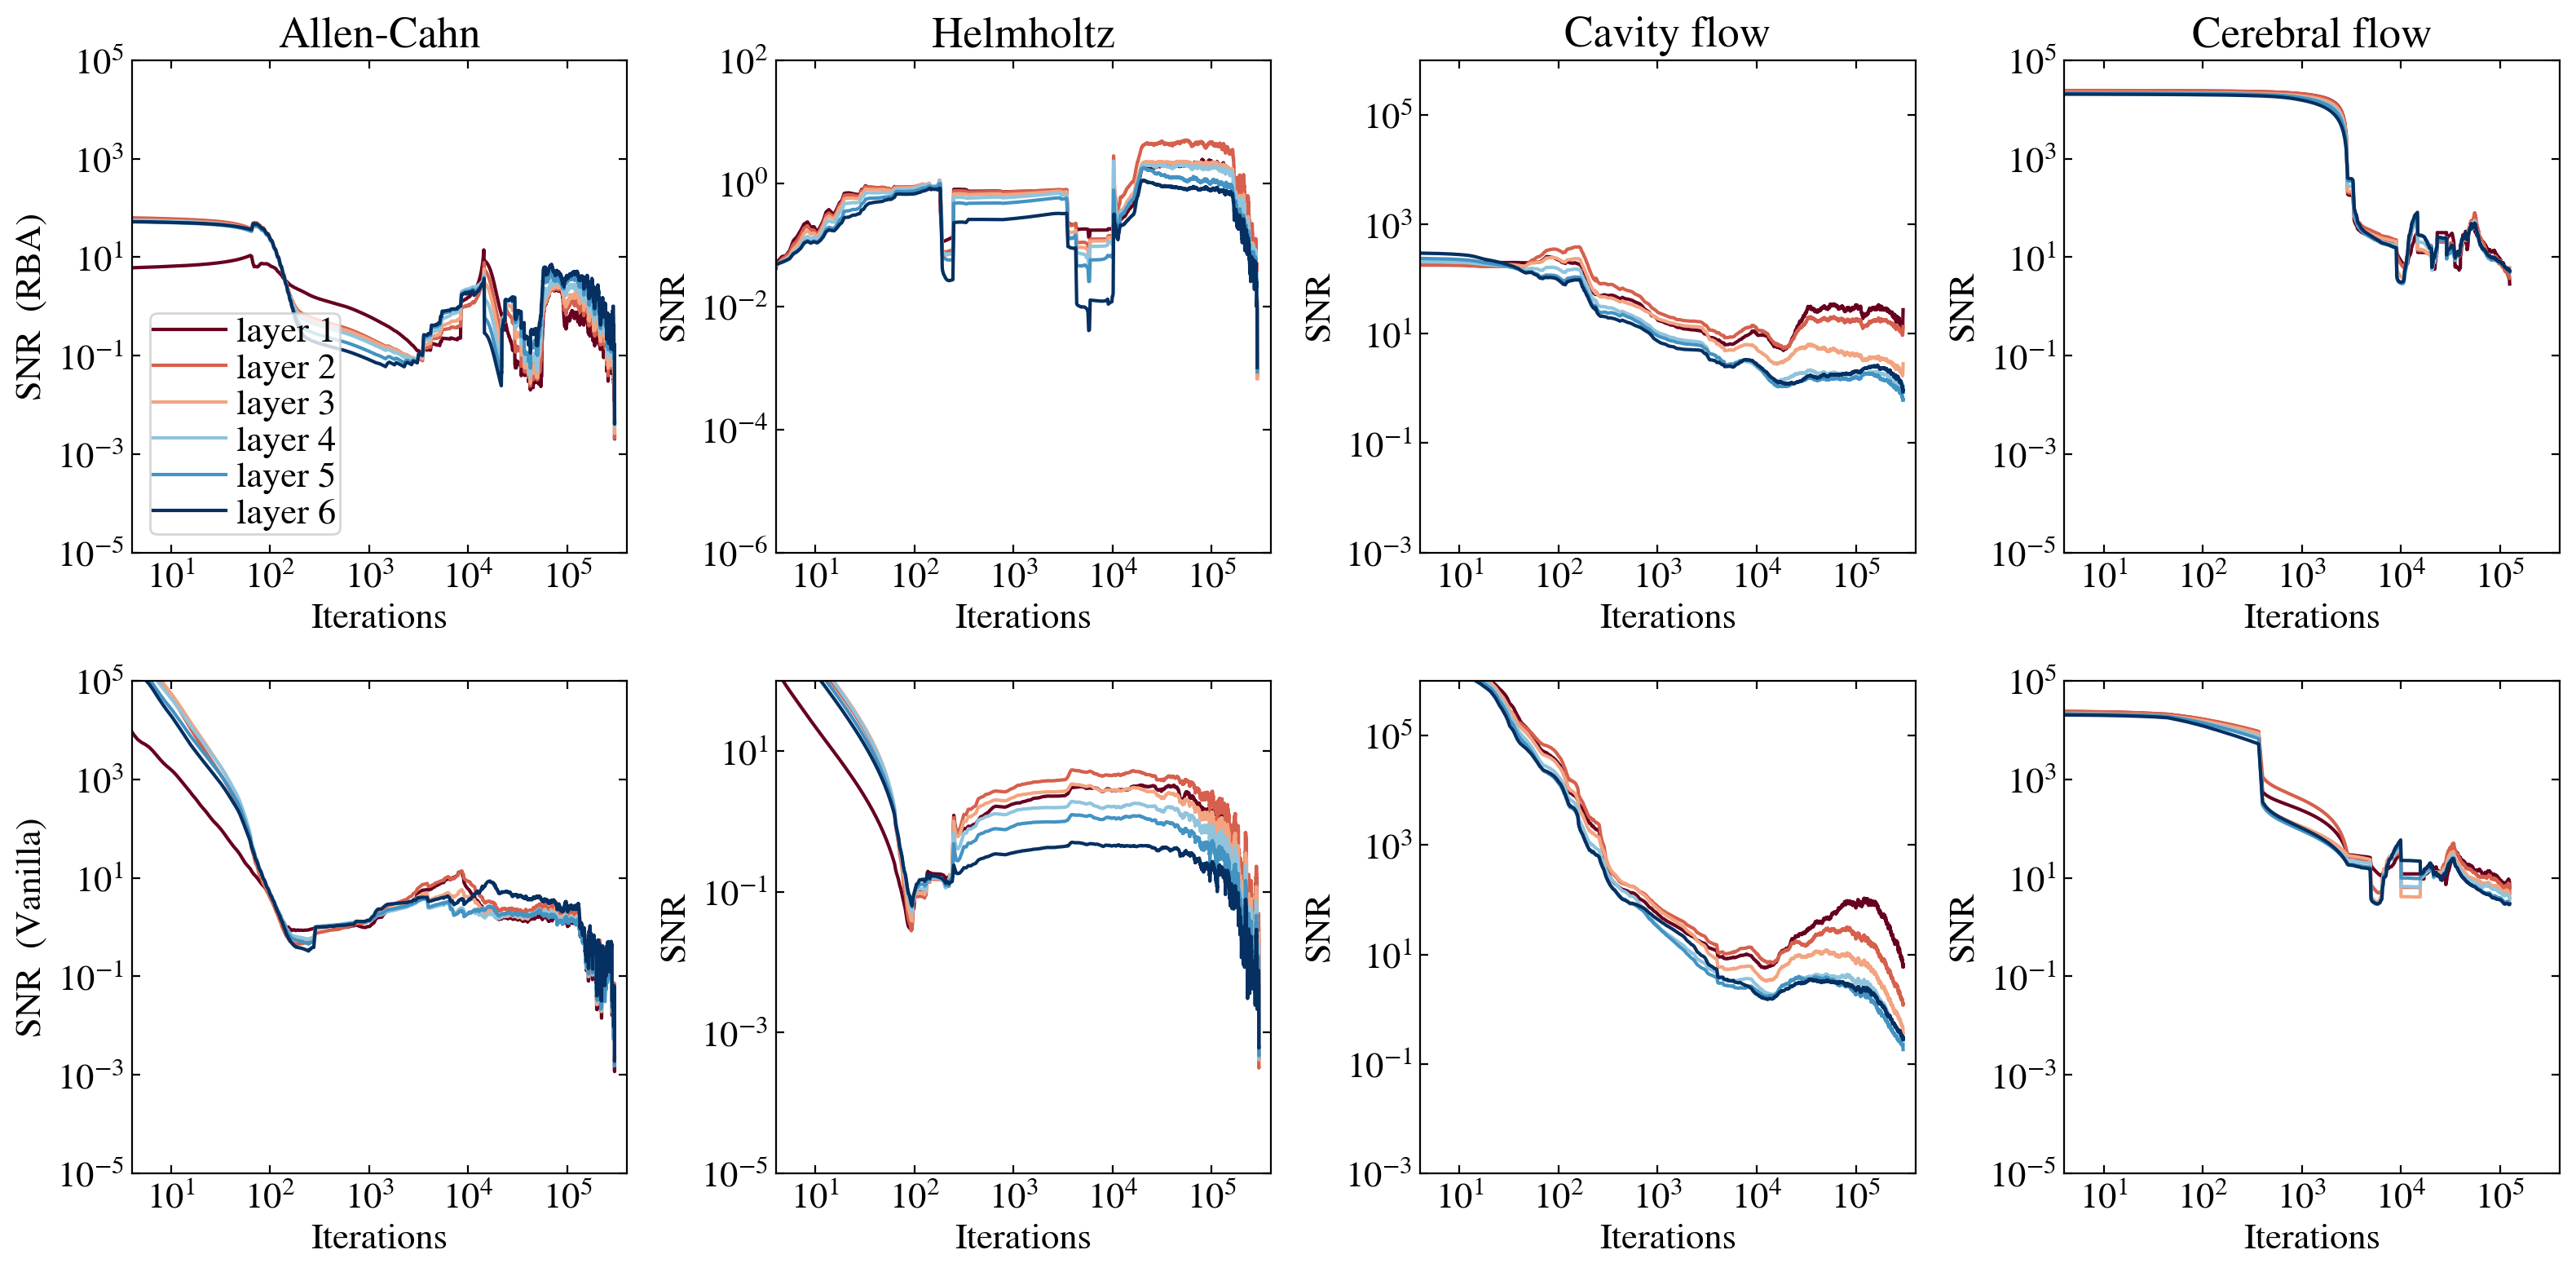

In [7]:
x1, y1 = np.linspace(0, 5e5, 100), np.ones(100)
window = 60
def plot_subplot(j, ax):
    # plt.plot(x1, y1, '--', color='black')
    if j == 4:
        layers = 6
        for i in range(0, layers):
            plot_snr_layers(i, ['Results/AC/r/grad_stats2.txt'], mode='snr',     window=window, layers=layers, lgnd=0)
        plt.ylim([1e-5, 1e5])
        plt.xlim([4, 4e5])
    elif j == 5:
        layers = 6
        for i in range(0, layers):
            # plot_snr_layers(i, ['Results/HM/grad_stats2.txt'], mode='snr',     window=window, layers=layers)
            plot_snr_layers(i, ['Results/HM/r2/grad_stats2.txt'], mode='snr',     window=window, layers=layers)
        plt.ylim([1e-5, 1e2])
        plt.xlim([4, 4e5])
    elif j == 7:
        layers = 8
        for i in range(0, layers-2):
            # plot_snr_layers(i, ['Results/BS/rba_final2/grad_stats2.txt'], mode='snr',     window=window, layers=layers, lgnd=0)
            plot_snr_layers(i, ['Results/BN/r/grad_stats2.txt'], mode='snr',   window=window, layers=layers, lgnd=0)
        plt.ylim([1e-5, 1e5])
        plt.xlim([4, 4e5])
    elif j == 6:
        layers = 6
        for i in range(0, layers):
            plot_snr_layers(i, ['Results/CV/r/grad_stats2.txt'], mode='snr',     window=window, layers=layers, lgnd=0)
        plt.ylim([1e-3, 1e6])
        plt.xlim([4, 4e5])
    elif j == 0:
        layers = 6
        for i in range(0, layers):
            plot_snr_layers(i, ['Results/AC/v/grad_stats2.txt'], mode='snr',     window=window, layers=layers, lgnd=1)
        plt.title('Allen-Cahn')
        plt.ylim([1e-5, 1e5])
        plt.xlim([4, 4e5])
    elif j == 1:
        layers = 6
        for i in range(0, layers):
            # plot_snr_layers(i, ['Results/HM/grad_stats2.txt'], mode='snr',     window=window, layers=layers)
            plot_snr_layers(i, ['Results/HM/v/grad_stats2.txt'], mode='snr',     window=window, layers=layers)
        plt.title('Helmholtz')
        plt.ylim([1e-6, 1e2])
        plt.xlim([4, 4e5])
    elif j == 3:
        layers = 8
        for i in range(0, layers-2):
            # plot_snr_layers(i, ['Results/BS/vanilla_final2/grad_stats2.txt'], mode='snr',     window=window, layers=layers, lgnd=0)
            plot_snr_layers(i, ['Results/BN/v/grad_stats2.txt'], mode='snr',   window=window, layers=layers, lgnd=0)
        plt.title('Cerebral flow')
        plt.ylim([1e-5, 1e5])
        plt.xlim([4, 4e5])
    elif j == 2:
        layers = 6
        for i in range(0, layers):
            plot_snr_layers(i, ['Results/CV/v/grad_stats2.txt'], mode='snr',     window=window, layers=layers, lgnd=0)
        plt.title('Cavity flow')
        plt.ylim([1e-3, 1e6])
        plt.xlim([4, 4e5])
        
# Create subplots
plt.figure(figsize=(16, 8), dpi=200)

for i in range(8):
    ax = plt.subplot(2, 4, i+1)
    plot_subplot(i, ax)
    if i == 0:
        plt.ylabel('SNR  (RBA)')
    elif i == 4:
        plt.ylabel('SNR  (Vanilla)')
    if i < 4:
        # plt.xticks([])
        plt.xticks([10, 100, 1000, 10000, 100000], ['$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$'])
    else:
        plt.xticks([10, 100, 1000, 10000, 100000], ['$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$'])
        plt.xlabel('Iterations')
# plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout(pad=0.9)
# plt.show()
plt.savefig('snr_layers.png')